In [6]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
from scipy.stats import randint, loguniform, rv_discrete
import dagshub

In [7]:
# set up dagshub for mlflow tracking
dagshub.init(repo_owner='JonaKoenemann', repo_name='machine_failure_classification', mlflow=True)


Initialized MLflow to track repo "JonaKoenemann/machine_failure_classification"

Repository JonaKoenemann/machine_failure_classification initialized!

# Data preparation

In [8]:
data_path = "../../../data/predictive_maintenance.csv"

In [9]:
df = pd.read_csv(data_path)

In [10]:
categorical_features = ['Type']
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('UDI')
numerical_features.remove('Target')

# Feature Engineering: Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', poly)
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [11]:
# Split for features (X) und labels (y)
X = df[numerical_features + categorical_features] # select Features 
y = df["Failure Type"]

In [12]:
# # Encode target variable as categorical
# y_encoded = pd.get_dummies(y).values # dimensions created does not work with gb model
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
# Split for test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [14]:
# Test preprocessor pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(X_train_transformed.shape)
print(X_test_transformed.shape)

(8000, 23)
(2000, 23)


In [15]:
def custom_max_depth_sampler():
    choices = [None] + list(range(3, 31))
    probs = np.ones(len(choices)) / len(choices)
    return np.random.choice(choices, p=probs, size=None, replace=True)


# Train and test

In [16]:
mlflow.set_experiment("gradient_boosting_classifier_rs_feature_encoded")

mlflow.sklearn.autolog()

model = GradientBoostingClassifier(random_state=42)

param_distributions = {
    'model__loss': ['log_loss'], 
    'model__learning_rate':loguniform(0.001, 0.1), #[0.01, 0.05, 0.1, 0.15, 0.2],
    'model__n_estimators': randint(100, 300),#[100, 150, 250, 300],
    'model__max_depth': [custom_max_depth_sampler()], # None or integer between 10 and 30
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 10)
}

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# weighted f1 score as scoring metric
scorer = make_scorer(f1_score, average = "weighted")


2024/07/05 09:45:13 INFO mlflow.tracking.fluent: Experiment with name 'gradient_boosting_classifier_rs_feature_encoded' does not exist. Creating a new experiment.


In [17]:
with mlflow.start_run():    
    # Set up RandomizedSearchCV
    randomized_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                           n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1, scoring=scorer)

    # Fit RandomizedSearchCV
    randomized_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = randomized_search.best_params_
    mlflow.log_params(best_params)
    print(f"\nbest params: {best_params}")

    # Get the best model
    best_model = randomized_search.best_estimator_

    # predicition
    y_pred = best_model.predict(X_test)

    # evaluation
    weighted_f1 = f1_score(y_true = y_test, y_pred= y_pred, average="weighted")
    print("\nweighted f1 score:", weighted_f1)
    mlflow.log_metric('weighted_f1_score', weighted_f1)
    
    mlflow.end_run()


2024/07/05 09:45:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/07/05 09:45:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these colum

Fitting 3 folds for each of 50 candidates, totalling 150 fits


2024/07/05 12:16:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/05 12:18:06 INFO mlflow.sklearn.utils: Logging the 5 best runs, 45 runs will be omitted.



best params: {'model__learning_rate': 0.026383097314635354, 'model__loss': 'log_loss', 'model__max_depth': 20, 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 195}

weighted f1 score: 0.9822238422209014


# Evaluation

In [18]:
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure'] # get names of errors in correct order for confusion matrix

## Classification report

In [19]:
print("Classification Report:")
report = classification_report(y_test, y_pred)
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.99      1.00      0.99      1935
           2       0.85      0.85      0.85        13
           3       0.84      0.80      0.82        20
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        11

    accuracy                           0.99      2000
   macro avg       0.61      0.60      0.60      2000
weighted avg       0.98      0.99      0.98      2000



c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Normalized consuion matrix

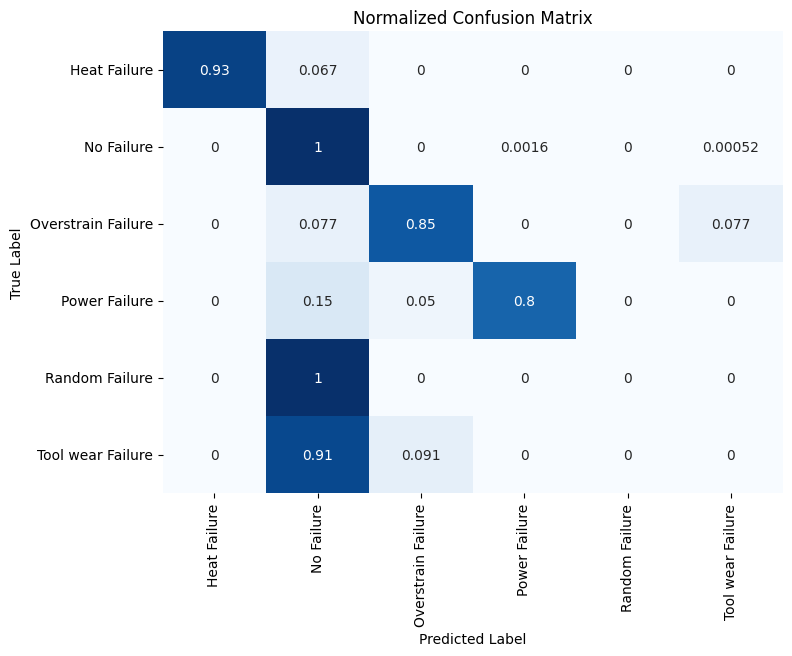

In [21]:
conf_matrix_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()